In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Inspect the input data
import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import normalizeIMG, real_files_to_tensors
from utils import normalizeTurn, unnormalize_params, unnormalizeTurn

from models import encoderDecoderModel

# some initializations
data_dir = './tomo_data/REAL_DATA_Run2'

IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

zeropad = 14
start_turn = 1
skipturns = 3
Ib = 1.16e11

normalization = 'minmax'
img_normalize = 'minmax'

var_names = ['phEr', 'enEr', 'bl','inten', 'Vrf', 'mu', 'VrfSPS']
loss_weights = [0, 1, 2, 4, 5, 6]


2023-01-19 09:42:34.539883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 09:42:34.773348: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 09:42:34.810662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-01-19 09:42:34

In [3]:
wf_test, wf_id = real_files_to_tensors(data_dir)
print(wf_test.shape)

(48, 128, 128, 1)


2023-01-19 09:42:41.703524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-01-19 09:42:41.703719: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 09:42:41.703735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-01-19 09:42:41.704822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

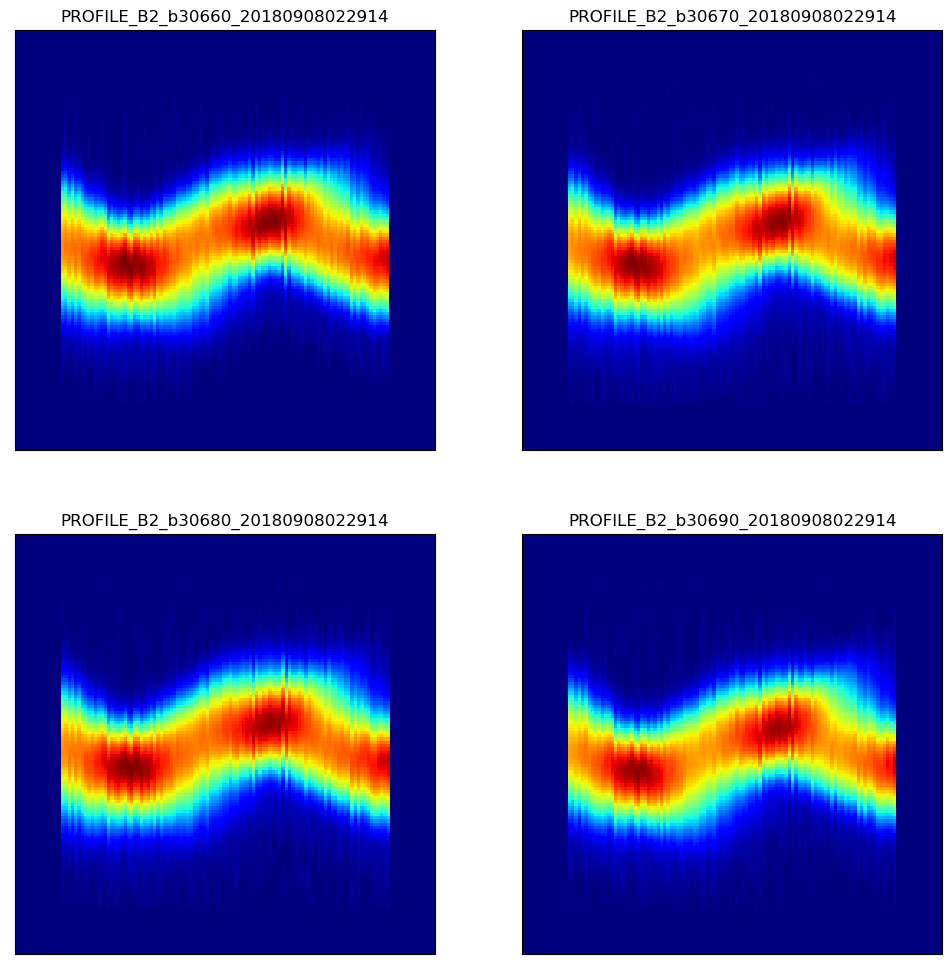

In [4]:
%matplotlib inline
# plot some of the outputs

nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(wf_test, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in sample[i]])
    ax.set_title(f'{wf_id[i]}')

## Testing the models on the real data

In [6]:
# Load the model
# Models to load
# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
# enc_timestamp = 'hybrid'
enc_timestamp = 'best_encoder_TF'

print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

# dec_timestamp = '2022_12_14_22-03-08'
dec_timestamp = 'best_decoder_TF_6in'
print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir,
 loss_weights=loss_weights)


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF_6in
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF_6in


In [45]:
# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(0, 300, num=31, endpoint=True, dtype=np.float32)
norm_turns = normalizeTurn(selected_turns)

In [48]:

def visual_evaluation(wf, wf_id, latent_pred, ps_pred, turn, figname):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, figsize=(12, 5), 
                            gridspec_kw={'width_ratios': [5, 2, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5], 
        normalization=normalization)
    
    # # start with left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    plt.xticks([], []); plt.yticks([], [])

    # center plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    plt.table(cellText=latent_pred_unnorm, rowLabels=rowLabels,
        colLabels=['Value'], loc='center')

    # top right plot
    plt.sca(axes[2])
    # print(f'PS Pred, min: {np.min(ps_pred)}, max: {np.max(ps_pred)}')
    plt.imshow(ps_pred, cmap='jet', vmin=-1, vmax=1)
    plt.title(f'Pred PS, Turn: {turn}', fontsize=14)
    plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    plt.savefig(figname, dpi=100)
    plt.close()



# Plot the predictions
for norm_turn in norm_turns:
    # expand turns to be equal to the number of test points
    turn_test = np.ones(len(wf_test), dtype=np.float32)*norm_turn
    # get the predictions
    latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)
    # Now I need to plot them
    # one directory per WF
    for i in range(len(wf_test)):
        unnorm_turn = int(unnormalizeTurn(norm_turn, maxTurns=300))

        # save in a figure the turn, latents, input image, output image
        os.makedirs(f'plots/real_data/{wf_id[i]}', exist_ok=True)
        figname = f'plots/real_data/{wf_id[i]}/turn_{unnorm_turn:03d}.png'
        visual_evaluation(wf_test[i], wf_id[i], 
                        latent_pred[i], ps_pred[i], 
                        unnorm_turn, figname)

        

## Experimentation

In [ ]:
fname = os.path.join(data_dir, 'PROFILE_B2_b30660_20180908022914.npy')

with open(fname, 'rb') as f:
    timeScale_for_tomo = np.load(f)
    BunchProfiles = np.load(f)

origProfiles = BunchProfiles.copy()

fig, ax_arr = plt.subplots(ncols=3)
plt.sca(ax_arr[0])
plt.plot(timeScale_for_tomo)

plt.sca(ax_arr[1])
plt.plot(origProfiles[:, 0])

# plt.show()
# print(timeScale_for_tomo.shape)
# print(BunchProfiles.shape)

BunchProfiles = BunchProfiles*Ib/np.sum(BunchProfiles[:, 0])
plt.sca(ax_arr[2])
plt.plot(BunchProfiles[:, 0])

# print(BunchProfiles.shape)


In [ ]:
def getTimgForModelFromDataFile(BunchProfiles, T_normFactor, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns, centroid_offset=0):
    # timeScale_for_tomo, BunchProfiles = getTimeProfiles_FromData(fname, Ib)
    BunchProfiles = BunchProfiles/T_normFactor
    sel_turns = np.arange(start_turn, skipturns *
                          (IMG_OUTPUT_SIZE-2*zeropad), skipturns).astype(np.int32)
    T_img = np.pad(BunchProfiles[:, sel_turns], ((zeropad-centroid_offset, zeropad +
                                                  centroid_offset), (zeropad, zeropad)), 'constant', constant_values=(0, 0))
    # T_img_ForModel = normalizeIMG(np.reshape(T_img, T_img.shape+(1,)))
    T_img_ForModel = np.reshape(T_img, T_img.shape+(1,))
    return T_img_ForModel

origTimg = getTimgForModelFromDataFile(origProfiles, 1, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns)
adjustedTimg = getTimgForModelFromDataFile(BunchProfiles, 1, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns)



In [ ]:
print(origTimg.shape)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = np.ravel(axes)
ax = axes[0]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(origTimg, cmap='jet')
print(np.min(origTimg), np.max(origTimg))
# Set the label
title = 'Orig'
ax.set_title(f'{title}')

ax = axes[1]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(adjustedTimg, cmap='jet')
print(np.min(adjustedTimg), np.max(adjustedTimg))

# Set the label
title = 'Adjusted'
ax.set_title(f'{title}')

# from sklearn.preprocessing import minmax_scale
def minmax_scale(X, feature_range=(0,1)):
    min_val = np.min(X)
    max_val = np.max(X)
    scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
    return scale * (X-min_val) + feature_range[0]

ax = axes[2]
ax.set_xticks([])
ax.set_yticks([])
# show the image
origTimg_scaled = minmax_scale(origTimg.reshape(IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
ax.imshow(origTimg_scaled, cmap='jet')
print(np.min(origTimg_scaled), np.max(origTimg_scaled))
# Set the label
title = 'Orig_scaled'
ax.set_title(f'{title}')

ax = axes[3]
ax.set_xticks([])
ax.set_yticks([])
# show the image
adjustedTimg_scaled = minmax_scale(adjustedTimg.reshape(IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
ax.imshow(adjustedTimg_scaled, cmap='jet')
print(np.min(adjustedTimg_scaled), np.max(adjustedTimg_scaled))

# Set the label
title = 'Adjusted_scaled'
ax.set_title(f'{title}')